In [14]:
# Import all necessary libraries for the task

import re
import string
import torch
import numpy as np
import pandas as pd
import nltk
import emoji

import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS

import transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModel
from transformers import Trainer, TrainingArguments
from transformers import AdamW
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from nltk.corpus import stopwords
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from transformers import BertTokenizerFast
from transformers import TFBertModel, TFAutoModelForSequenceClassification
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


clf = CountVectorizer()
X_train_cv = clf.fit_transform(X_train)clf = CountVectorizer()
X_train_cv = clf.fit_transform(X_train)#########################################################

In [16]:
df_train = pd.read_csv('/kaggle/input/input-data/HODI_2023_train_subtaskA.tsv', sep='\t')
df_test = pd.read_csv('/kaggle/input/input-data/HODI_2023_test_subtaskA.csv', sep='\t')

In [17]:
df_train.head()

,id,text,homotransphobic
0,1,Hanno rotto le #palle con i €compleanni a #dop...,0
1,2,"@user_abc Avete rotto,come potete prendere se ...",0
2,3,Guevara si è rotto il cazzo e ha mandato a far...,0
3,4,@user_abcd Se io volessi entrare in un bar con...,0
4,5,@user_abcdef @user_abc @user_abcdefgh Ok nessu...,0


In [18]:
df_test.info()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1000 non-null   int64 
 1   text    1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5000 non-null   int64 
 1   text             5000 non-null   object
 2   homotransphobic  5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


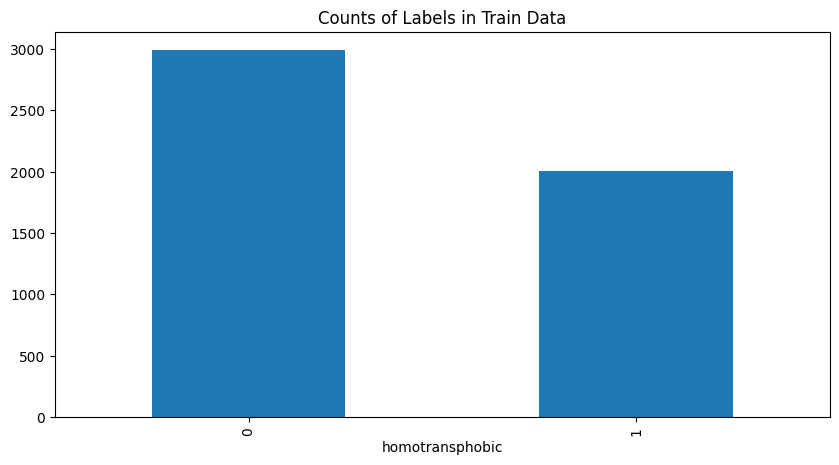

In [19]:
labels_train = df_train["homotransphobic"].value_counts().sort_index().plot(
 kind='bar',
 title='Counts of Labels in Train Data',
 figsize=(10, 5))

plt.show()

In [ ]:
# df_train = df_train[["text", "homotransphobic"]]

In [ ]:
# df_test = df_test[["text"]]

In [20]:
def pre_process(text): 
    text = text.lower() 
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) 
    text = re.sub(r"@\w+", "", text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('#', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('RT|rt', '', text)
    text = text.strip()
    return text

In [21]:
df_train["text"] = df_train["text"].apply(pre_process)
df_test["text"] = df_test["text"].apply(pre_process)

In [22]:
# Get Italian stopwords from nltk
italian_stopwords = set(stopwords.words('italian'))
# Add specific stopwords to the set
italian_stopwords.update(["RT", "rt", "URL"])

# Join all the text data in the selected rows where "homotransphobic" is 1
text_to_generate_wordcloud = " ".join(df_train.loc[df_train["homotransphobic"] == 1]["text"])

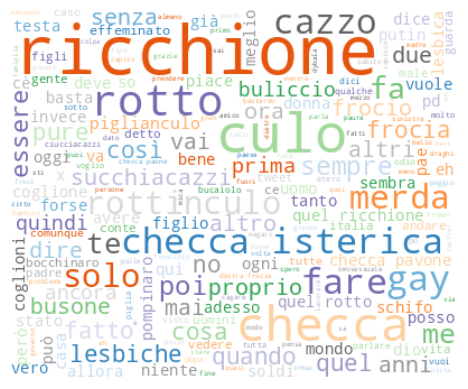

In [23]:
wordcloud = WordCloud(
    background_color='white',
    stopwords=italian_stopwords,
    width=400,
    height=330,
    colormap='tab20c',
    collocations=True,
    max_words=200,
    max_font_size=60,
    random_state=42
).generate(text_to_generate_wordcloud)

fig = plt.figure(1)
plt.imshow(wordcloud.recolor(random_state=3), interpolation="bilinear")
plt.axis('off')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


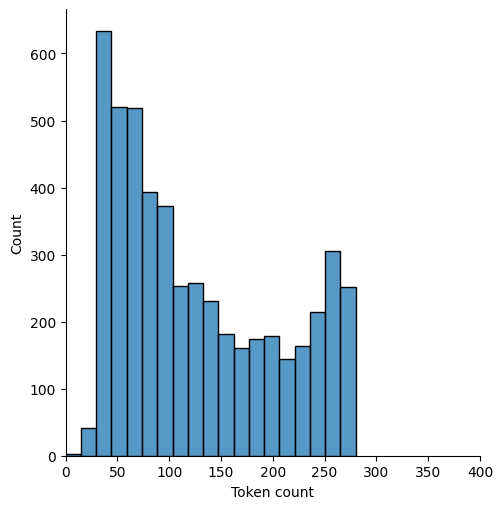

In [24]:
token_lens = []

for txt in df_train.text:
  token_lens.append(len(txt))

sns.displot(token_lens)
plt.xlim([0, 400]);
plt.xlabel('Token count');

In [25]:
X = df_train["text"].values
y = df_train["homotransphobic"].values

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=48)

In [27]:
X_test = df_test['text'].values

In [28]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape

((4500,), (500,), (4500,), (500,), (1000,))

In [31]:
# Naive Bayes Classifier

clf = CountVectorizer() # transform a given text into a vector on the basis of the frequency (count) of each word 
X_train_cv = clf.fit_transform(X_train) # resulting X_train_cv is a sparse matrix where each row represents a document, 
                                        # and each column represents a unique word in the entire corpus

In [32]:
# We create TF-IDF of tokenized tweets

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv) #TF-IDF on sparse matrix - see which words are relevant
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(clf.transform(X_test))

In [33]:
# Fitting Naive Bayes classifier

nb_clf = MultinomialNB()

nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [34]:
# Classifier is then used to predict labels for class data
nb_pred = nb_clf.predict(X_test_tf)

In [37]:
from sklearn.metrics import classification_report

gold_path = '/kaggle/input/gold-truth/HODI_2023_test_GOLD.tsv'  # Change this to the actual path of your ground truth file
data_gold = pd.read_csv(gold_path, sep='\t', converters={'id': str, 'homotransphobic': int})

# Assuming 'homotransphobic' is the column containing true labels in the gold data
y_true = data_gold['homotransphobic']

classification_rep_test = classification_report(y_true, nb_pred)

# Print the classification report for the test set
print("Classification Report on the test set:\n", classification_rep_test)

# Print confusion matrix
conf_matrix = confusion_matrix(y_true, nb_pred)
print("Confusion Matrix for Test Set:\n", conf_matrix)

Classification Report on the test set:
               precision    recall  f1-score   support

           0       0.53      0.99      0.69       489
           1       0.94      0.14      0.25       511

    accuracy                           0.56      1000
   macro avg       0.73      0.57      0.47      1000
weighted avg       0.74      0.56      0.46      1000

Confusion Matrix for Test Set:
 [[484   5]
 [437  74]]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [38]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression Classifier
logreg_clf = LogisticRegression()

# Vectorize and transform the text data using TF-IDF
X_train_cv = clf.fit_transform(X_train)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)

# Train logistic regression classifier
logreg_clf.fit(X_train_tf, y_train)

# Make predictions on the validation set
X_valid_cv = clf.transform(X_valid)
X_valid_tf = tf_transformer.transform(X_valid_cv)
y_pred_valid_logreg = logreg_clf.predict(X_valid_tf)

# Evaluate the logistic regression classifier on the validation set
accuracy_valid_logreg = accuracy_score(y_valid, y_pred_valid_logreg)
print(f"Accuracy on the validation set (Logistic Regression): {accuracy_valid_logreg:.2f}")

# Make predictions on the test set
X_test_cv = clf.transform(X_test)
X_test_tf = tf_transformer.transform(X_test_cv)
y_pred_test_logreg = logreg_clf.predict(X_test_tf)

# Assuming truth_labels is the true labels for the test set
# Get the full classification report for the test set using logistic regression
classification_rep_test_logreg = classification_report(y_true, y_pred_test_logreg)

# Print the classification report for the test set using logistic regression
print("Classification Report on the test set (Logistic Regression):\n", classification_rep_test_logreg)

# Print confusion matrix for logistic regression
conf_matrix_logreg = confusion_matrix(y_true, y_pred_test_logreg)
print("Confusion Matrix for Test Set (Logistic Regression):\n", conf_matrix_logreg)

Accuracy on the validation set (Logistic Regression): 0.77
Classification Report on the test set (Logistic Regression):
               precision    recall  f1-score   support

           0       0.59      0.90      0.71       489
           1       0.80      0.41      0.54       511

    accuracy                           0.65      1000
   macro avg       0.70      0.65      0.62      1000
weighted avg       0.70      0.65      0.62      1000

Confusion Matrix for Test Set (Logistic Regression):
 [[438  51]
 [304 207]]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [39]:
MAX_LEN = 161

In [42]:
# Load the BERT model from HuggingFace
MODEL = f"Musixmatch/umberto-wikipedia-uncased-v1"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2, from_pt=True)

All PyTorch model weights were used when initializing TFCamembertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFCamembertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
# After pre-processing, tokenization every word in data

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)  # Save input_ids and attention_masks as Numpy Arrays

In [44]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [45]:
def create_model(bert_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    outputs = bert_model([input_ids, attention_masks])

    # Extract the logits from TFSequenceClassifierOutput
    logits = outputs.logits

    # Modify the pooling 
    pooled = tf.reduce_mean(logits, axis=1)
    
    # Reshape the pooled tensor to (None, 1)
    pooled = tf.keras.layers.Reshape((1,))(pooled)

    output = tf.keras.layers.Dense(1, activation="sigmoid")(pooled)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    return model

In [46]:
model = create_model(model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 161)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 161)]                0         []                            
                                                                                                  
 tf_camembert_for_sequence_  TFSequenceClassifierOutput   1106234   ['input_1[0][0]',             
 classification (TFCamember  (loss=None, logits=(None,    90         'input_2[0][0]']             
 tForSequenceClassification  2),                                                                  
 )                            hidden_states=None, atten                                       

In [47]:
history_bert = model.fit([train_input_ids,train_attention_masks], # Inputs from tokenzied data for training
                         y_train, # Labels for training
                         validation_data=([val_input_ids,val_attention_masks], 
                                          y_valid), # Splitting for validation data using y_Valid defined before
                         epochs=4, batch_size=32) 

Epoch 1/4
141/141 [==============================] - 200s 1s/step - loss: 0.6598 - binary_accuracy: 0.6102 - val_loss: 0.6234 - val_binary_accuracy: 0.6580
Epoch 2/4
141/141 [==============================] - 142s 1s/step - loss: 0.5795 - binary_accuracy: 0.7067 - val_loss: 0.5175 - val_binary_accuracy: 0.7740
Epoch 3/4
141/141 [==============================] - 142s 1s/step - loss: 0.4719 - binary_accuracy: 0.7882 - val_loss: 0.4654 - val_binary_accuracy: 0.8000
Epoch 4/4
141/141 [==============================] - 142s 1s/step - loss: 0.4016 - binary_accuracy: 0.8344 - val_loss: 0.4534 - val_binary_accuracy: 0.8080


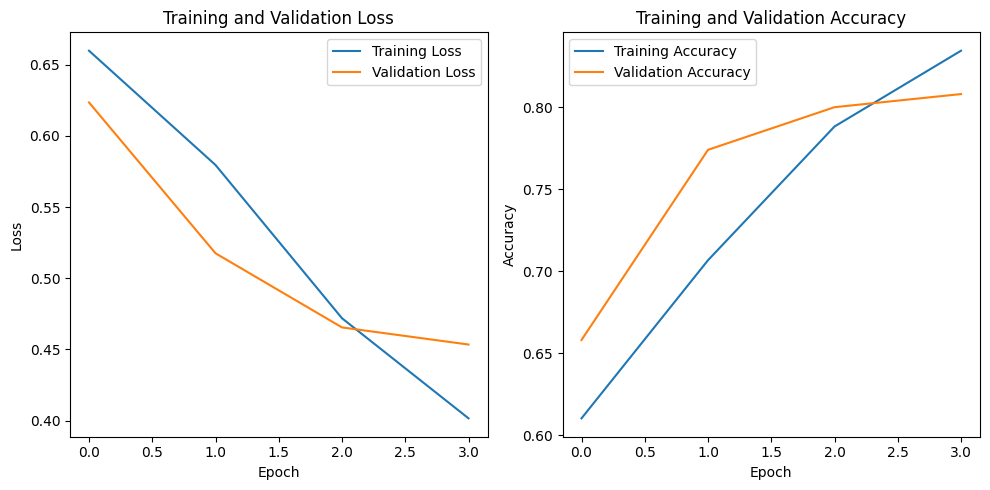

In [49]:
train_loss = history_bert.history['loss']
val_loss = history_bert.history['val_loss']
train_accuracy = history_bert.history['binary_accuracy']  
val_accuracy = history_bert.history['val_binary_accuracy']  

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
# Predict the outputs for the test set

result_bert = model.predict([test_input_ids,test_attention_masks])

32/32 [==============================] - 14s 319ms/step


In [56]:
model.save("saved_model/umberto_model1.h5")

In [53]:
threshold = 0.5 
binary_predictions = (result_bert > threshold).astype(int)

In [54]:
# Assuming `binary_predictions` is your predicted labels for the test data
predictions_df = pd.DataFrame({"id": df_test["id"], "homotransphobic": binary_predictions.flatten()})
predictions_df.to_csv("predictions.csv", sep="\t", index=False)

In [57]:
!zip -r umberto1.zip /kaggle/working/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/predictions.csv (deflated 71%)
  adding: kaggle/working/saved_model/ (stored 0%)
  adding: kaggle/working/saved_model/alberto_model.keras (deflated 18%)
  adding: kaggle/working/saved_model/umberto_model1.h5 (deflated 18%)
  adding: kaggle/working/saved_model/umberto_model1.keras (deflated 18%)
  adding: kaggle/working/saved_model/alberto_model.h5 (deflated 18%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)


In [130]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load ground truth labels
gold_path = '/kaggle/input/gold-truth/HODI_2023_test_GOLD.tsv'  # Change this to the actual path of your ground truth file
data_gold = pd.read_csv(gold_path, sep='\t', converters={'id': str, 'homotransphobic': int})

# Assuming 'homotransphobic' is the column containing true labels in the gold data
y_true = data_gold['homotransphobic']

# Load model predictions
predictions_file = '/kaggle/input/predictions/matteo.alberto.run1.tsv'  # Change this to the actual path of your predictions file
predictions_df = pd.read_csv(predictions_file, sep='\t')

# Assuming 'homotransphobic' is the column containing predicted labels in the predictions file
y_pred = predictions_df['homotransphobic']

# Calculate evaluation metrics
#accuracy = accuracy_score(y_true, y_pred)
#precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

#print("Accuracy:", accuracy)
#print("Precision:", precision)
#print("Recall:", recall)
#print("F1 Score:", f1)
#print("Confusion Matrix:")
print("TN:", tn, " FP:", fp)
print("FN:", fn, " TP:", tp)

classification_rep = classification_report(y_true, y_pred)

# Print the classification report
print("Classification Report:")
print(classification_rep)

TN: 454  FP: 35
FN: 283  TP: 228
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.93      0.74       489
           1       0.87      0.45      0.59       511

    accuracy                           0.68      1000
   macro avg       0.74      0.69      0.66      1000
weighted avg       0.74      0.68      0.66      1000



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

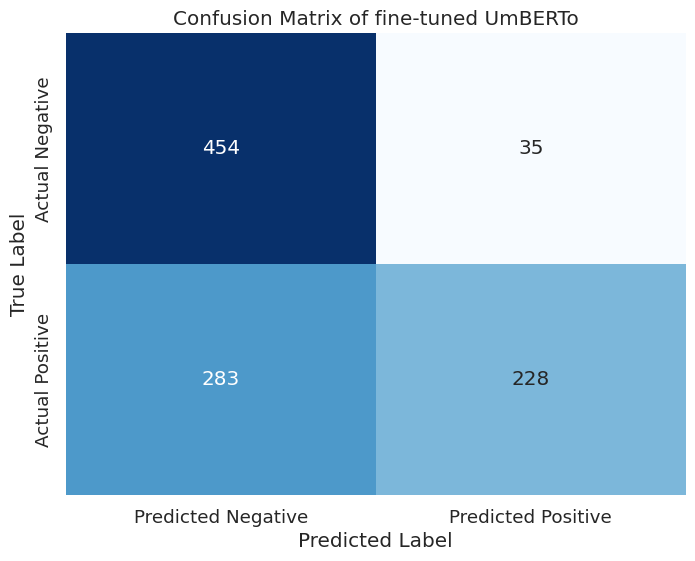

In [131]:
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of fine-tuned UmBERTo')
plt.show()

In [132]:
plt.savefig('saved_model/umberto_confmat.png')

<Figure size 640x480 with 0 Axes>

In [65]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Load ground truth labels
gold_path = '/kaggle/input/gold-truth/HODI_2023_test_GOLD.tsv'
data_gold = pd.read_csv(gold_path, sep='\t', converters={'id': str, 'homotransphobic': int})
y_true = data_gold['homotransphobic']

# Load model predictions
predictions_file = '/kaggle/input/predictions/matteo.alberto.run1.tsv'
predictions_df = pd.read_csv(predictions_file, sep='\t')
y_pred = predictions_df['homotransphobic']

# Get indices of False Positives and False Negatives
false_positive_indices = [i for i in range(len(y_true)) if (y_true[i] == 0 and y_pred[i] == 1)]
false_negative_indices = [i for i in range(len(y_true)) if (y_true[i] == 1 and y_pred[i] == 0)]

# Extract the original text for False Positives and False Negatives
false_positive_texts = data_gold.loc[false_positive_indices, 'text']
false_negative_texts = data_gold.loc[false_negative_indices, 'text']

# Create a DataFrame for False Positives
false_positive_df = pd.DataFrame({'Predicted Label': 1, 'Actual Label': 0, 'Text': false_positive_texts})

# Create a DataFrame for False Negatives
false_negative_df = pd.DataFrame({'Predicted Label': 0, 'Actual Label': 1, 'Text': false_negative_texts})

# Combine both DataFrames into a single DataFrame
combined_df = pd.concat([false_positive_df, false_negative_df], ignore_index=True)

# Save the combined DataFrame to a CSV file
combined_df.to_csv('false_predictions_umberto.csv', index=False)

# Model: AlBERTo
trained on Twitter data. So theoratically bettter?

In [98]:
# Load the BERT model from HuggingFace
MODEL_ALBERTO = f"m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"

tokenizer_alberto = AutoTokenizer.from_pretrained(MODEL)
model_alberto = TFAutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2, from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [99]:
df_train = pd.read_csv('/kaggle/input/input-data/HODI_2023_train_subtaskA.tsv', sep='\t')
df_test = pd.read_csv('/kaggle/input/input-data/HODI_2023_test_subtaskA.csv', sep='\t')

In [100]:
df_train["text"] = df_train["text"].apply(pre_process)
df_test["text"] = df_test["text"].apply(pre_process)

In [102]:
X = df_train["text"].values
y = df_train["homotransphobic"].values

In [104]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=48)

In [105]:
X_test = df_test['text'].values

In [106]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape

((4500,), (500,), (4500,), (500,), (1000,))

In [107]:
# After pre-processing, tokenization every word in data

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)  # Save input_ids and attention_masks as Numpy Arrays

In [108]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [110]:
def create_model(bert_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    outputs = bert_model([input_ids, attention_masks])

    # Extract the logits from TFSequenceClassifierOutput
    logits = outputs.logits

    # Modify the pooling 
    pooled = tf.reduce_mean(logits, axis=1)
    
    # Reshape the pooled tensor to (None, 1)
    pooled = tf.keras.layers.Reshape((1,))(pooled)

    output = tf.keras.layers.Dense(1, activation="sigmoid")(pooled)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    return model

In [111]:
model_alberto = create_model(model_alberto, MAX_LEN)
model_alberto.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 161)]                0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 161)]                0         []                            
                                                                                                  
 tf_bert_for_sequence_class  TFSequenceClassifierOutput   1843468   ['input_7[0][0]',             
 ification_3 (TFBertForSequ  (loss=None, logits=(None,    82         'input_8[0][0]']             
 enceClassification)         2),                                                                  
                              hidden_states=None, atten                                     

In [112]:
history_alberto = model_alberto.fit([train_input_ids,train_attention_masks], # Inputs from tokenzied data for training
                         y_train, # Labels for training
                         validation_data=([val_input_ids,val_attention_masks], 
                                          y_valid), # Splitting for validation data using y_Valid defined before
                         epochs=4, batch_size=32) 

Epoch 1/4
141/141 [==============================] - 196s 1s/step - loss: 0.5863 - binary_accuracy: 0.7071 - val_loss: 0.5695 - val_binary_accuracy: 0.7360
Epoch 2/4
141/141 [==============================] - 144s 1s/step - loss: 0.4339 - binary_accuracy: 0.8238 - val_loss: 0.4662 - val_binary_accuracy: 0.8100
Epoch 3/4
141/141 [==============================] - 144s 1s/step - loss: 0.3472 - binary_accuracy: 0.8760 - val_loss: 0.4649 - val_binary_accuracy: 0.8040
Epoch 4/4
141/141 [==============================] - 144s 1s/step - loss: 0.2756 - binary_accuracy: 0.9096 - val_loss: 0.4988 - val_binary_accuracy: 0.7840


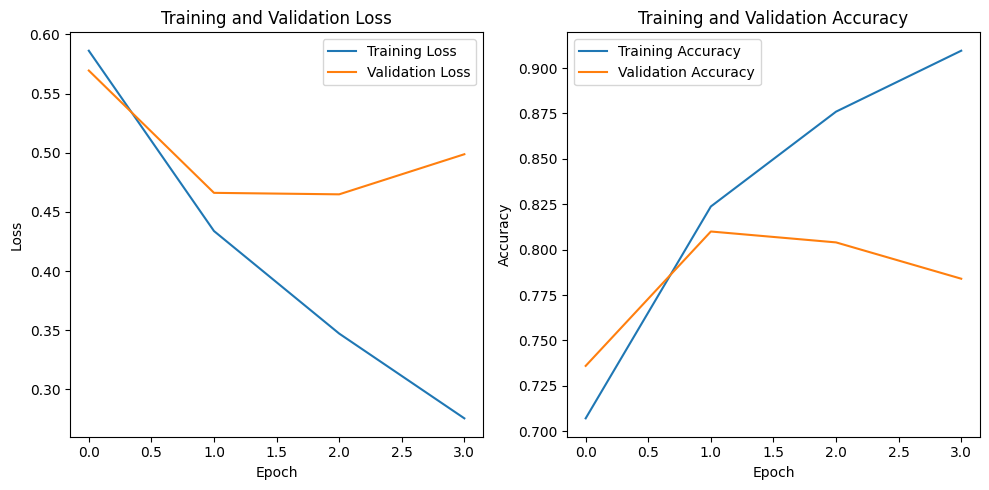

In [113]:
train_loss = history_alberto.history['loss']
val_loss = history_alberto.history['val_loss']
train_accuracy = history_alberto.history['binary_accuracy']  
val_accuracy = history_alberto.history['val_binary_accuracy']  

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [114]:
# Predict the outputs for the test set

result_alberto = model_alberto.predict([test_input_ids,test_attention_masks])

32/32 [==============================] - 14s 334ms/step


In [125]:
threshold = 0.5 
binary_predictions = (result_alberto > threshold).astype(int)

predictions_alberto_df = pd.DataFrame({"id": df_test["id"], "homotransphobic": binary_predictions.flatten()})
predictions_alberto_df.to_csv("alberto/predictions_alberto.tsv", sep="\t", index=False)

In [119]:
model.save("alberto/alberto_model.keras")

/opt/conda/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [126]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load ground truth labels
gold_path = '/kaggle/input/gold-truth/HODI_2023_test_GOLD.tsv'  # Change this to the actual path of your ground truth file
data_gold = pd.read_csv(gold_path, sep='\t', converters={'id': str, 'homotransphobic': int})

# Assuming 'homotransphobic' is the column containing true labels in the gold data
y_true = data_gold['homotransphobic']

# Load model predictions
predictions_file = '/kaggle/working/alberto/predictions_alberto.tsv'  # Change this to the actual path of your predictions file
predictions_df = pd.read_csv(predictions_file, sep="\t")

# Assuming 'homotransphobic' is the column containing predicted labels in the predictions file
y_pred = predictions_df['homotransphobic']

# Calculate evaluation metrics
#accuracy = accuracy_score(y_true, y_pred)
#precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

#print("Accuracy:", accuracy)
#print("Precision:", precision)
#print("Recall:", recall)
#print("F1 Score:", f1)
#print("Confusion Matrix:")
print("TN:", tn, " FP:", fp)
print("FN:", fn, " TP:", tp)

classification_rep = classification_report(y_true, y_pred)

# Print the classification report
print("Classification Report:")
print(classification_rep)

TN: 390  FP: 99
FN: 116  TP: 395
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       489
           1       0.80      0.77      0.79       511

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.78      1000
weighted avg       0.79      0.79      0.79      1000



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

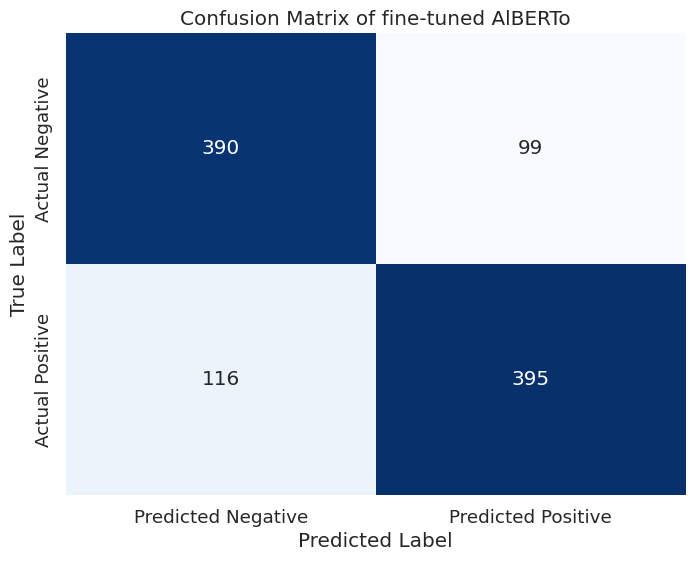

In [128]:
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of fine-tuned AlBERTo')
plt.show()

In [129]:
plt.savefig('alberto/alberto_confmat.png')

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ground_truth_data = pd.read_csv('/kaggle/input/input-data/HODI_2023_test_GOLD.tsv', sep='\t')
ground_truth_labels = ground_truth_data['homotransphobic']

# Convert probabilities to binary predictions
y_pred_bert = np.round(result_bert).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(ground_truth_labels, binary_predictions)
print(conf_matrix)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import shap

In [ ]:
explainer = shap.Explainer(model, masker=[tokenizer.decode, tokenizer.decode])

In [ ]:
shap_values = explainer([input_ids.numpy(), attention_masks.numpy()])

In [ ]:
confusion_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')